In [1]:
! pip install -q kaggle

from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

! mkdir mri_dataset

! unzip brain-tumor-mri-dataset.zip -d mri_dataset

! kaggle datasets download -d rahimanshu/figshare-brain-tumor-classification
! mkdir glioma_dataset
! unzip figshare-brain-tumor-classification.zip -d glioma_dataset

! kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri
! mkdir validation_dataset
! unzip brain-tumor-classification-mri.zip -d validation_dataset

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: glioma_dataset/glioma/906.jpg  
  inflating: glioma_dataset/glioma/907.jpg  
  inflating: glioma_dataset/glioma/908.jpg  
  inflating: glioma_dataset/glioma/909.jpg  
  inflating: glioma_dataset/glioma/910.jpg  
  inflating: glioma_dataset/glioma/911.jpg  
  inflating: glioma_dataset/glioma/912.jpg  
  inflating: glioma_dataset/glioma/913.jpg  
  inflating: glioma_dataset/glioma/914.jpg  
  inflating: glioma_dataset/glioma/915.jpg  
  inflating: glioma_dataset/glioma/916.jpg  
  inflating: glioma_dataset/glioma/917.jpg  
  inflating: glioma_dataset/glioma/918.jpg  
  inflating: glioma_dataset/glioma/919.jpg  
  inflating: glioma_dataset/glioma/920.jpg  
  inflating: glioma_dataset/glioma/921.jpg  
  inflating: glioma_dataset/glioma/922.jpg  
  inflating: glioma_dataset/glioma/923.jpg  
  inflating: glioma_dataset/glioma/924.jpg  
  inflating: glioma_dataset/glioma/925.jpg  
  inflating: glioma_dataset/glioma/926.jp

In [2]:
# TensorFlow e Keras
import tensorflow as tf
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils.vis_utils import plot_model
from keras import regularizers

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, class_weight
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

# Outras bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
from tqdm import tqdm
import os
import warnings
from itertools import cycle

# Configurações
%config Completer.use_jedi = False
warnings.simplefilter("ignore")

In [3]:
np.random.RandomState(10)
tf.random.set_seed(10)

In [4]:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

X_treino = []
Y_treino = []

X_teste = []
Y_teste = []

image_size = 64

glioma_folder_path = os.path.join('/content/glioma_dataset', 'glioma')

glioma_images = []
for j in tqdm(os.listdir(glioma_folder_path)):
    img = cv2.imread(os.path.join(glioma_folder_path,j))
    img = cv2.resize(img,(image_size, image_size))
    glioma_images.append(img)

glioma_labels = ['glioma'] * len(glioma_images)

glioma_images, glioma_labels = shuffle(glioma_images, glioma_labels)

glioma_images_train, glioma_images_test, glioma_labels_train, glioma_labels_test = train_test_split(
    glioma_images, glioma_labels, test_size=0.2
)

X_treino.extend(glioma_images_train)
Y_treino.extend(glioma_labels_train)
X_teste.extend(glioma_images_test)
Y_teste.extend(glioma_labels_test)

for i in class_names:
    if i != 'glioma':
        folderPath = os.path.join('/content/mri_dataset','Training',i)
        for j in tqdm(os.listdir(folderPath)):
            img = cv2.imread(os.path.join(folderPath,j))
            img = cv2.resize(img,(image_size, image_size))
            X_treino.append(img)
            Y_treino.append(i)

        folderPath = os.path.join('/content/mri_dataset','Testing',i)
        for j in tqdm(os.listdir(folderPath)):
            img = cv2.imread(os.path.join(folderPath,j))
            img = cv2.resize(img,(image_size, image_size))
            X_teste.append(img)
            Y_teste.append(i)

100%|██████████| 300/300 [00:00<00:00, 344.43it/s]


In [5]:
#X_treino, Y_treino = shuffle(X_treino, Y_treino, random_state=10)
#X_teste, Y_teste = shuffle(X_teste, Y_teste, random_state=10)

In [6]:
X_treino = np.array(X_treino)
Y_treino = np.array(Y_treino)

X_teste = np.array(X_teste)
Y_teste = np.array(Y_teste)

In [7]:
X_treino = X_treino/255.0
X_teste = X_teste/255.0

In [8]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(Y_treino),
                                                 y = Y_treino)

weight = {i : class_weights[i] for i in range(4)}
    
print(weight)

{0: 1.212938596491228, 1: 1.032673637042569, 2: 0.8669278996865204, 3: 0.9490391214824982}


In [9]:
Y_treino = np.unique(Y_treino, return_inverse = True)[1]
Y_teste = np.unique(Y_teste, return_inverse = True)[1]

In [10]:
Y_treino_count = np.bincount(Y_treino)

total = np.sum([Y_treino_count], axis=1)[0]

print(
    'Training:\n    Total: {}\n    Glioma: {} ({:.2f}% of total)\n    Meningioma: {} ({:.2f}% of total)\n    No Tumor: {} ({:.2f}% of total)\n    Pituitary: {} ({:.2f}% of total)'.format(
    total, 
    Y_treino_count[0], 100 * Y_treino_count[0] / total, 
    Y_treino_count[1], 100 * Y_treino_count[1] / total, 
    Y_treino_count[2], 100 * Y_treino_count[2] / total, 
    Y_treino_count[3], 100 * Y_treino_count[3] / total, ))

Training:
    Total: 5531
    Glioma: 1140 (20.61% of total)
    Meningioma: 1339 (24.21% of total)
    No Tumor: 1595 (28.84% of total)
    Pituitary: 1457 (26.34% of total)


In [11]:
Y_teste_count = np.bincount(Y_teste)

total = np.sum([Y_teste_count], axis=1)[0]

print(
    'Test:\n    Total: {}\n    Glioma: {} ({:.2f}% of total)\n    Meningioma: {} ({:.2f}% of total)\n    No Tumor: {} ({:.2f}% of total)\n    Pituitary: {} ({:.2f}% of total)'.format(
    total, 
    Y_teste_count[0], 100 * Y_teste_count[0] / total, 
    Y_teste_count[1], 100 * Y_teste_count[1] / total, 
    Y_teste_count[2], 100 * Y_teste_count[2] / total, 
    Y_teste_count[3], 100 * Y_teste_count[3] / total, ))

Test:
    Total: 1297
    Glioma: 286 (22.05% of total)
    Meningioma: 306 (23.59% of total)
    No Tumor: 405 (31.23% of total)
    Pituitary: 300 (23.13% of total)


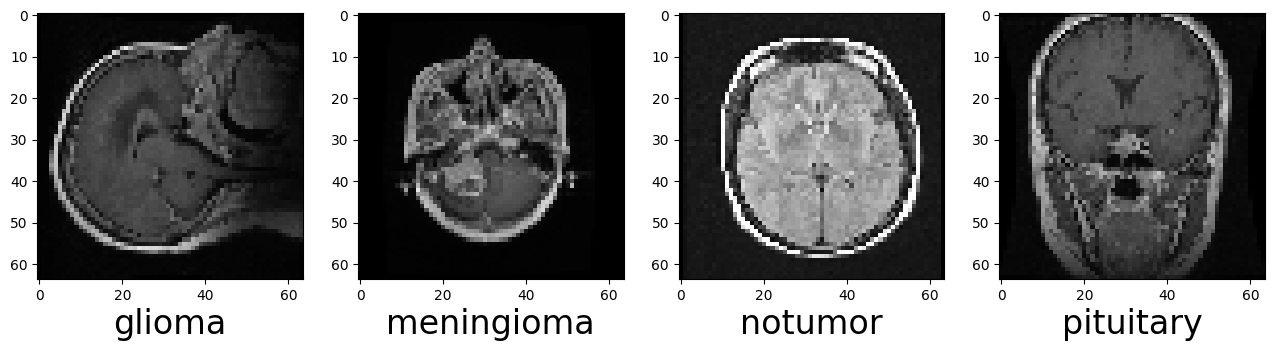

In [12]:
plt.figure(figsize=(20,20))

sum = 800
for i in range(4):
    plt.subplot(5,5,i+1)
    plt.imshow(X_treino[i + sum])
    plt.xlabel(class_names[Y_treino[i + sum]], fontsize=24)

    sum = sum + 1350
plt.show()

In [13]:
def get_model():

    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                    input_shape=(image_size,image_size,3), padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Dropout(0.20))

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))             
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.30))

    model.add(Flatten())

    model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
    
    return model

In [14]:
#! pip install visualkeras

#import visualkeras
#from PIL import ImageFont

model = get_model()

#font = ImageFont.truetype("Roboto-Regular.ttf", 24)
#visualkeras.layered_view(model, legend=True, font=font)

#model.summary()
#plot_model(model, to_file='model_plot.png', show_shapes = True, 
#           show_layer_names = False, show_layer_activations = True)

In [15]:
erlstp = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=18)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights/weights.hdf5',
    verbose=1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [16]:
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS, BATCH_SIZE, class_w):
    model = None
    model = get_model()
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE,
                validation_data = (val_x, val_y),
                class_weight=class_w,
                callbacks=[erlstp, reduce_lr, model_checkpoint], verbose=1)  
    
    print("\nValidation Score: ", model.evaluate(val_x, val_y))
    return results

In [17]:
n_folds=5
epochs=60
batch_size=32

model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ", i + 1)

    X_t, X_v, label_t, label_v = train_test_split(
      X_treino, Y_treino, test_size = 0.2
    )

    X_t, label_t = shuffle(X_t, label_t)
                                               
    model_history.append(fit_and_evaluate(X_t, X_v, label_t, label_v, epochs, batch_size, weight))
    print("=======" * 12, end="\n\n\n")

Training on Fold:  1
Epoch 1/60
139/139 [==============================] - ETA: 0s - loss: 1.0594 - accuracy: 0.6958
Epoch 1: val_accuracy improved from -inf to 0.83830, saving model to weights/weights.hdf5
139/139 [==============================] - 13s 8ms/step - loss: 1.0594 - accuracy: 0.6958 - val_loss: 0.7017 - val_accuracy: 0.8383 - lr: 0.0010
Epoch 2/60
132/139 [===========================>..] - ETA: 0s - loss: 0.5644 - accuracy: 0.8757
Epoch 2: val_accuracy improved from 0.83830 to 0.86992, saving model to weights/weights.hdf5
139/139 [==============================] - 1s 5ms/step - loss: 0.5611 - accuracy: 0.8761 - val_loss: 0.5387 - val_accuracy: 0.8699 - lr: 0.0010
Epoch 3/60
131/139 [===========================>..] - ETA: 0s - loss: 0.4763 - accuracy: 0.8919
Epoch 3: val_accuracy improved from 0.86992 to 0.88437, saving model to weights/weights.hdf5
139/139 [==============================] - 1s 5ms/step - loss: 0.4720 - accuracy: 0.8915 - val_loss: 0.4486 - val_accuracy: 0.

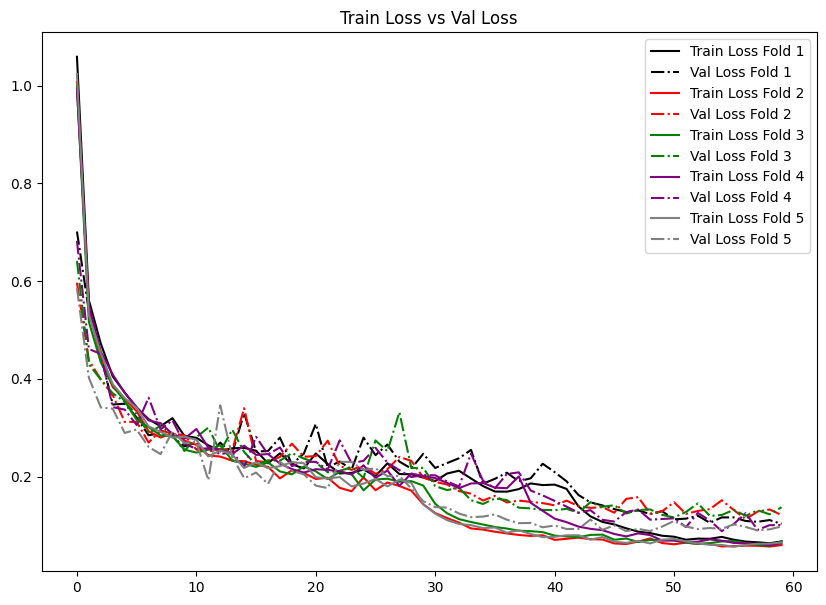

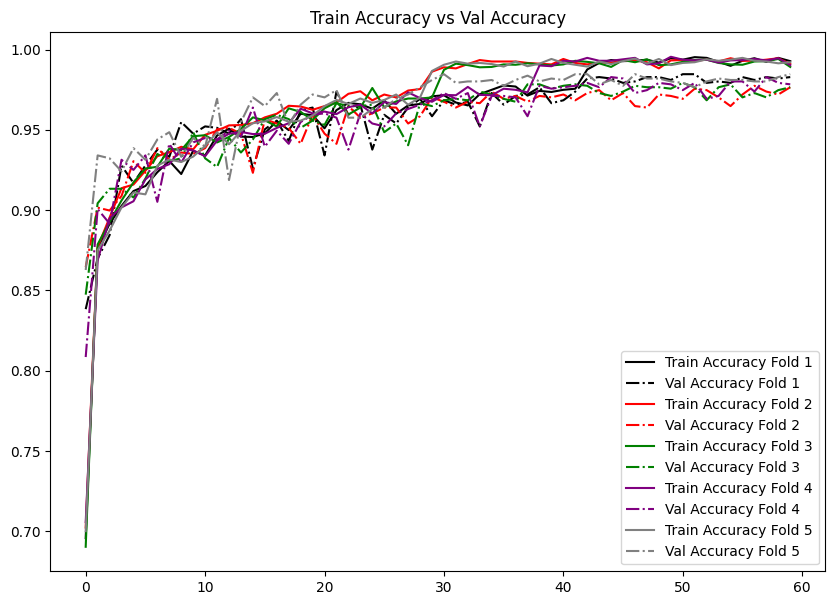

In [18]:
colors = ['black', 'red', 'green', 'purple', 'gray']
labels = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']

plt.figure(figsize=(10,7))
plt.title('Train Loss vs Val Loss')
for i, color in enumerate(colors):
    plt.plot(model_history[i].history['loss'], label='Train Loss '+labels[i], color=color)
    plt.plot(model_history[i].history['val_loss'], label='Val Loss '+labels[i], color=color, linestyle = "dashdot")
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.title('Train Accuracy vs Val Accuracy')
for i, color in enumerate(colors):
    plt.plot(model_history[i].history['accuracy'], label='Train Accuracy '+labels[i], color=color)
    plt.plot(model_history[i].history['val_accuracy'], label='Val Accuracy '+labels[i], color=color, linestyle = "dashdot")
plt.legend()
plt.show()


In [19]:
model = load_model('weights/weights.hdf5')

results = model.evaluate(X_teste, Y_teste)
print("Loss: {:0.4f}".format(results[0]))

41/41 [==============================] - 0s 3ms/step - loss: 0.1144 - accuracy: 0.9846
Loss: 0.1144


In [20]:
predicted_classes = model.predict(X_teste)
predicted_classes = np.argmax(np.round(predicted_classes), axis = 1)

print(classification_report(Y_teste, predicted_classes, target_names = class_names))

41/41 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00       286
  meningioma       0.98      0.96      0.97       306
     notumor       0.98      0.99      0.99       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.98      1297
   macro avg       0.99      0.98      0.98      1297
weighted avg       0.98      0.98      0.98      1297



In [21]:
predicted_probs = model.predict(X_teste)

Y_teste_bin = label_binarize(Y_teste, classes=[0, 1, 2, 3])

41/41 [==============================] - 0s 2ms/step


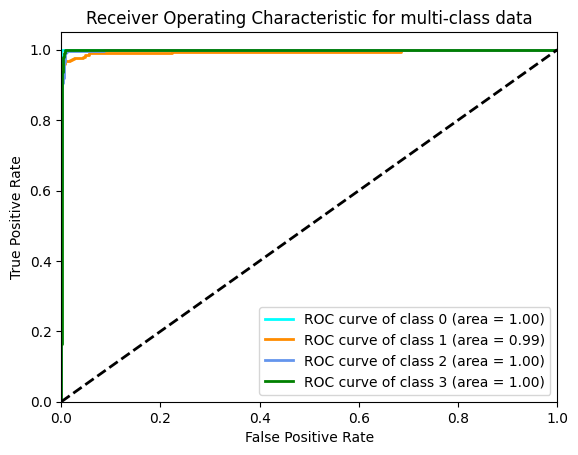

In [22]:
n_classes = 4

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_teste_bin[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


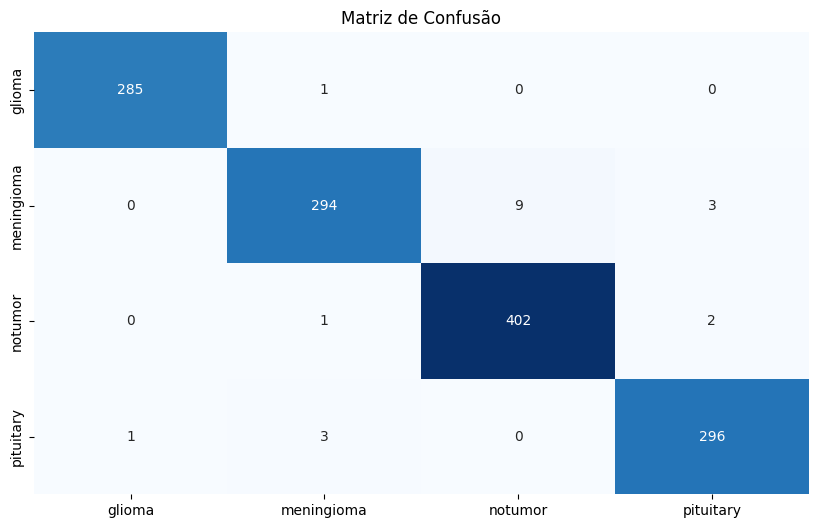

In [23]:
cmat = confusion_matrix(Y_teste, predicted_classes)
cm_df = pd.DataFrame(cmat) 

cmat_df = pd.DataFrame(cmat,
                     index = class_names, 
                     columns = class_names)

plt.figure(figsize=(10,6))

sns.heatmap(cmat, annot = True, cmap = 'Blues', fmt = "d",
            cbar = False,
            xticklabels = class_names,
            yticklabels = class_names)

plt.title('Matriz de Confusão')
plt.show()

In [24]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [33]:
#img = cv2.imread('test image here')
#orig_img = img
#img = cv2.resize(img, (image_size, image_size))

#img = img.astype('float32') / 255.0

#x = np.array(img)
#x = np.expand_dims(x, axis=0)

#layer_name = 'convolutional layer here'

#heatmap = make_gradcam_heatmap(x, model, layer_name)

#orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

#heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
#heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

#heatmap_resized = cv2.resize(heatmap_colored, (orig_img.shape[1], orig_img.shape[0]))

#superimposed_img = np.uint8(heatmap_resized * 0.5 + orig_img * 0.5)

#plt.figure(figsize=(10,5))

#plt.subplot(1, 2, 1)
#plt.imshow(orig_img)
#plt.title('Original Image')

#plt.subplot(1, 2, 2)
#plt.imshow(superimposed_img)
#plt.title('Grad-CAM')

#plt.show()
